<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/Copy_of_ce_ensemble_cancer_random_initial_weights_decorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_validation_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ce_ensemble_cancer_random_initial_weights_decorrelation

> Currently main idea is the following: pretrain ensemble in supervised fashion, with a score "decorrelation" term.

In [1]:
#| default_exp ce_ensemble_cancer_random_initial_weights_decorrelation

In [2]:
#| hide
# import os
# from google.colab import drive

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():
    from google.colab import drive
    import os
    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')

    os.chdir('cancer-proj')
    
    os.system('pip install .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [3]:
import os
os.system('pip install .')
os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')

0

In [4]:
#| hide
from nbdev.showdoc import *

In [5]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from cancer_proj.cancer_maintrain_ensemble import *
from cancer_proj.cancer_maintrain_ce import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module

import fastai
test_eq(fastai.__version__,'2.7.11')

import torch
test_eq(torch.__version__,'1.13.1+cu116')


## Load the data

In [6]:
#| hide

#Since we have cloned repository and cd'd into it (and the data itself is not stored in the
#repo) we need cd out of it, get the data, then cd back into the repo `cancer-proj`.
#This is a bit annoying, can maybe remove this later
if on_colab:
    #os.chdir('..') #assumes we are currently in cancer-proj directory
    train_dir = colab_train_dir
    test_dir = colab_test_dir
else:
    train_dir = local_train_dir
    test_dir = local_test_dir

#define general hps
device ='cuda' if torch.cuda.is_available() else 'cpu'
bs_test=297
bs=32 #256 if doing BT though...
bs_tune=32
size=128
bs_val=174

#get the data dictionary
data_dict = get_fnames_dls_dict(train_dir=train_dir,test_dir=test_dir,
                    device=device,bs_val=bs_val,bs=bs,bs_tune=bs_tune,size=size,n_in=3)

#get the dataloaders
dls_train,dls_tune,dls_valid,dls_test = data_dict['dls_train'],data_dict['dls_tune'],data_dict['dls_valid'],data_dict['dls_test']
x,y = data_dict['x'],data_dict['y']
xval,yval = data_dict['xval'],data_dict['yval']
xtune,ytune = data_dict['xtune'],data_dict['ytune']
vocab = data_dict['vocab']

#If we want to write some tests (make sure the data is same every time etc):
fnames,fnames_train,fnames_tune,fnames_valid,fnames_test = data_dict['fnames'],data_dict['fnames_train'],data_dict['fnames_tune'],data_dict['fnames_valid'],data_dict['fnames_test']

#test_eq(x.shape,xtune.shape)

# if on_colab:
#     os.chdir('cancer-proj')

# Test data is of expected form:

In [7]:
test_data(fnames_train,fnames_valid,fnames_test)
test_dls_data(train_dir,test_dir,device)

test_eq(len(dls_test.train),5) #test set is 297*5 = 1485


## Load aug pipelines here

In [8]:
#| hide

aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

In [9]:
#aug_pipelines_tune = [aug_pipelines_tune[0],aug_pipelines_tune[0]]

## Optionally, display:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


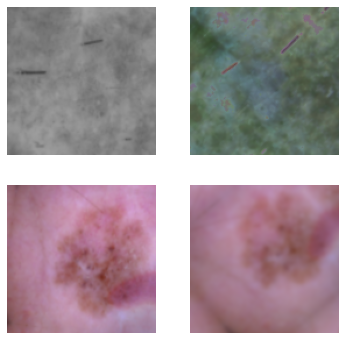

In [10]:
#| hide
show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: 


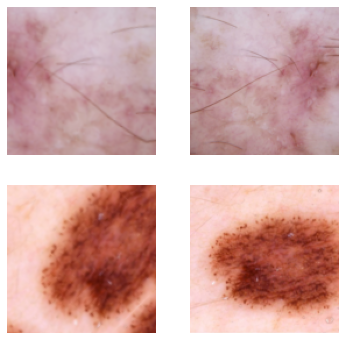

In [11]:
#| hide

show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

In [12]:
#| hide
#show_btens_batch(dls_train,3,aug_pipelines,n=2)

## Step 1) Train two BT models on CIFAR10, and save them

In [13]:
import os

directory = '/content/drive/My Drive/random_initial_weights'

if not os.path.exists(directory):
    os.makedirs(directory)

In [14]:
len(aug_pipelines_tune)

1

# Train a simple model with CE idea

In [15]:
# class BarlowTwinsModel(Module):
#     """An encoder followed by a projector
#     """
#     def __init__(self,encoder,projector):
#         self.encoder = encoder
#         self.projector = projector
        
#     def forward(self,x): 
        
#         return self.projector(self.encoder(x))

# def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
#     "Create Barlow Twins model"
#     n_in  = in_channels(encoder)
#     with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
#     projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
#     apply_init(projector)
#     return BarlowTwinsModel(encoder, projector)


In [155]:
class CeJointEnsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,encoder2,head,head2,projector):
        self.encoder = encoder
        self.encoder2 = encoder2
        self.head=head
        self.head2=head2
        self.projector=projector

    def forward(self,x):
        tem=self.encoder(x)
        tem2=self.encoder2(x)
        return self.projector(tem),self.projector(tem2),self.head(tem),self.head2(tem2)

        #return tem,tem2,self.head(tem),self.head2(tem2)


def create_joint_ens_model(encoder,encoder2,head,head2, hidden_size=8192, projection_size=8192, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return CeJointEnsModel(encoder,encoder2,head,head2, projector)


In [17]:
#| export

class CeJointEns(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in, lmb=5e-3,numout=10, print_augs=False,show_batch=False):
        #self.aug1, self.aug2 = aug_pipelines
        
        #self.aug = aug_pipelines #c.f. LinearBt
        self.aug1= aug_pipelines[0]
        self.aug2=Pipeline( split_idx = 0) #empty pipeline

        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.n_in=n_in
        self.cross_entropy = CrossEntropyLossFlat()
        self.numout=numout
        self._show_batch=show_batch

        self.t=None
        self.s=None
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        #nf = self.learn.model.encoder[-1].out_features
        self.nf = 8192
        self.I = torch.eye(self.nf).to(self.dls.device)


    def before_epoch(self):
        pass
  
    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))                            
        elif self.n_in == 3:
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (xi,)

        if self._show_batch:
            self.learn.aug_x = torch.cat([xi, xj])        

    @torch.no_grad()
    def show(self, n=1):
        if self._show_batch==False:
            print('Need to set show_batch=True')
            return
        bs = self.learn.aug_x.size(0)//2
        x1,x2  = self.learn.aug_x[:bs], self.learn.aug_x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)


#class CeIndiv(CeJointEns):pass

In [18]:
#| export

class CeJointEnsBt(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in, lmb=5e-3,numout=10, print_augs=False):
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.n_in=n_in
        self.cross_entropy = CrossEntropyLossFlat()
        self.numout=numout
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        #nf = self.learn.model.encoder[-1].out_features
        self.nf = 8192
        self.I = torch.eye(self.nf).to(self.dls.device)


    def before_epoch(self):
        pass
  
    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:

            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
            
            #print(xi.shape)
                                    
        elif self.n_in == 3:
            
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))

        self.learn.xb = (torch.cat([xi, xj]),)
        
    def lf(self,pred,*yb): pass
        

    @torch.no_grad()
    def show(self, n=1): 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)


class CeIndiv(CeJointEns):pass

In [19]:
import torch.nn.functional as F

In [157]:
#| export

def lf_ce2(pred,*yb,t,s,criterion=CrossEntropyLossFlat()):
    "Loss function for training ensemble jointly "
    

    pred,pred2,out,out2 = pred[0],pred[1],pred[2],pred[3] #proj(enc)_1, proj(enc)_2, head(enc)_1, head(enc_2)
    #bs,nf = pred.size(0)//2,pred.size(1)
    bs,nf = pred.size(0),pred.size(1)

    # test_eq(bs,32)
    # test_eq(nf,8192)

    y = yb[0]

    # test_eq(pred.shape,torch.Size([32, 8192]))
    # test_eq(pred2.shape,torch.Size([32, 8192]))
    # test_eq(out.shape,torch.Size([32, 9]))
    # test_eq(out2.shape,torch.Size([32, 9]))


    #this should throw an error now...
    # z1,z2 = pred[:bs],pred[bs:]
    # z1_2,z2_2 = pred2[:bs],pred2[bs:]


    #Barlow twins cross correlation
    z1norm = (pred - pred.mean(0)) / (pred.std(0, unbiased=False) + 1e-7)
    z2norm = (pred2 - pred2.mean(0)) / (pred2.std(0, unbiased=False) + 1e-7)
    C = (z1norm.T @ z2norm) / bs
    cdiff = C.pow(2)
    rr = cdiff.sum()

    #VICReg style hinge variance:
    _x = pred - pred.mean(dim=0)
    _y = pred2 - pred2.mean(dim=0)

    std_x = torch.sqrt(_x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(_y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    CE1 = criterion(out,y)
    CE2 = criterion(out2,y)
    CE = (0.5*CE1 + 0.5*CE2)


    rr = t*rr

    #print(f'rr is: {rr}')

    loss = CE + rr + std_loss


    return loss



In [105]:
from random import random

random()

0.22536210965770154

In [138]:
#| export

def lf_ce3(pred,*yb,t,s,criterion=CrossEntropyLossFlat()):
    "Loss function for training ensemble jointly "
    

    pred,pred2,out,out2 = pred[0],pred[1],pred[2],pred[3] #proj(enc)_1, proj(enc)_2, head(enc)_1, head(enc_2)
    
    bs,nf = pred.size(0)//2,pred.size(1)

    z1norm = (pred - pred.mean(0)) / (pred.std(0, unbiased=False) + 1e-7)
    z2norm = (pred2 - pred2.mean(0)) / (pred2.std(0, unbiased=False) + 1e-7)
    # if random()<0.5:
    #     z1norm=z1norm.detach()
    # else:
    #     z2norm=z2norm.detach()

    #z2norm = z2norm.detach()


    C = (z1norm.T @ z2norm) / bs
    cdiff = C.pow(2)
    rr = cdiff.sum()

    
    #bs,nf = pred.size(0),pred.size(1)

    #out_1,out_2 = out[:bs],out[bs:]
    
    #out2_1,out2_2 = out2[:bs],out2[bs:]


    # test_eq(bs,32)
    # test_eq(nf,8192)

    y = yb[0]


    CE = 0.5*(criterion(out,y) + criterion(out2,y))


    loss=CE + t*rr

    return loss



In [131]:
#| export

def lf_ce4(pred,*yb,criterion=CrossEntropyLossFlat()):
    "Loss function for training ensemble jointly "
    
    bs,nf = pred.size(0)//2,pred.size(1)
    #bs,nf = pred.size(0),pred.size(1)

    out_1,out_2 = pred[:bs],pred[bs:]


    y = yb[0]


    loss = 0.5*(criterion(out_1,y) + criterion(out_2,y))

    return loss



In [22]:
@patch
def before_epoch(self:CeJointEnsBt):
    self.t=0
    self.s=0

In [163]:
@patch
def before_epoch(self:CeJointEns):


    # if self.epoch == 0:
    #     #self.t=0.0
    #     self.t = 0.005*(1/2048)

    # if self.epoch==10:
    #     self.t = 0.0025*(1/2048)

    # if self.epoch == 40:
    #     self.t=0.5*self.t

    if self.epoch == 0:
    #self.t=0.0
        self.t = 0.0025*(1/8192)

    if self.epoch==10:
        self.t = 0.001*(1/8192)

    if self.epoch == 40:
        self.t=0.5*self.t





        #input('about to set t~=0')

    # if self.epoch<10:
    #     self.t=0.1
    # if self.epoch == 10:
    #     self.t=0.05

    # if self.epoch == 35:
    #     self.t=0.01

    # if self.epoch == 0:
    #     self.t=1

    # if self.epoch ==1:
    #     self.t=0.5

    # if self.epoch == 5:
    #     self.t=0.2

    # if self.epoch == 10:
    #     self.t=0.1

    # if self.epoch == 15:
    #     self.t=0.05

    #we will anneal these


In [158]:
#| export
@patch
def lf(self:CeJointEns, pred,*yb): return lf_ce2(pred,*yb,t=self.t,s=self.s,criterion=CrossEntropyLossFlat())

In [83]:
#| export
assert False
@patch
def lf(self:CeJointEns, pred,*yb): return lf_ce3(pred,*yb,t=self.t,s=self.s,criterion=CrossEntropyLossFlat())

In [43]:
#| export
@patch
def lf(self:CeJointEnsBt, pred,*yb): return lf_ce4(pred,*yb,criterion=CrossEntropyLossFlat())

We want to freeze the encoder, and learn the projector and head(s) for a few epochs

In [26]:
# def ce_joint_splitter(m):

#     return L(sequential(m.encoder,m.encoder2),sequential(m.head,m.head2,m.projector)).map(params)

def ce_joint_splitter(m):

    return L(sequential(m.encoder,m.encoder2),sequential(m.head,m.head2)).map(params)

In [27]:
# def diff_lr_splitter(m):

#     return L(sequential(m.encoder,m.head),sequential(m.encoder2,m.head2,m.projector)).map(params)

def diff_lr_splitter(m):

    return L(sequential(m.encoder,m.head),sequential(m.encoder2,m.head2)).map(params)

#Verify splitter freeze appropriately:

In [ ]:
with torch.no_grad():
    #use two "good" pretrained models!
    _,encoder = create_model('bt_pretrain',device='cpu')
    _,encoder2 = create_model('supervised_pretrain',device='cpu')

    #ce_joint_model = CeJointEnsModel(encoder=encoder,encoder2=encoder2,head=nn.Linear(2048,9),head2=nn.Linear(2048,9))
    
    ce_joint_model = create_joint_ens_model(encoder=encoder,encoder2=encoder2,head=nn.Linear(2048,9),
                                            head2=nn.Linear(2048,9)
                                            )
# print('created joint model')
# #TODO
# #splitter = ce_joint_splitter
learn = Learner(dls_tune,ce_joint_model,splitter=ce_joint_splitter,cbs=[CeJointEns(aug_pipelines_tune,n_in=3,numout=9,lmb=None,print_augs=False)])
learn.create_opt()
# learn = Learner(dls_tune,ce_joint_model,splitter=ce_joint_splitter,cbs=[CeJointEns(aug_pipelines_tune,n_in=3,numout=9,lmb=None,print_augs=False)])
# learn.freeze()
# learn.summary()

In [ ]:
lr_max_sup

In [ ]:
# learn = Learner(dls_tune,ce_joint_model,splitter=diff_lr_splitter,cbs=[CeJointEns(aug_pipelines_tune,n_in=3,numout=9,lmb=None,print_augs=False)])

# learn.fit_one_cycle(epochs,slice(lr_sup,lr_bt))

In [ ]:
lr_max_sup

In [37]:
class CeIndivModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,head):
        self.encoder = encoder
        self.head=head

    def forward(self,x):
        tem=self.encoder(x)
        return self.head(tem)

In [75]:
# #Phase 1: low amount of augmentation:

# with torch.no_grad():
#     _,encoder = create_model(which_model='supervised_pretrain',ps=8192,device=device)

#     model = LM(encoder,numout=len(dls_tune.vocab))


#     learn = Learner(dls_tune,model,splitter=my_splitter,
#                     cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,
#                                     n_in=3,tune_model_path=None,
#                                     tune_save_after=1)],wd=0.0
                    
#                     )
# learn.freeze()
# learn.fit(1)
# learn.unfreeze()
# learn.fit_one_cycle(10,lr_max_sup)


In [76]:
#Phase 2: LARGE amount of augmentation

# with torch.no_grad():
#     _,encoder = create_model(which_model='supervised_pretrain',ps=8192,device=device)
#     model = LM(encoder,numout=len(dls_tune.vocab))


# model = CeIndivModel(encoder = model.encoder,head=model.head)#head=nn.Linear(2048,len(dls_tune.vocab)).cuda())

# learn = Learner(dls_tune,model,splitter=my_splitter,
#                 cbs=[CeJointEnsBt(aug_pipelines,n_in=3,numout=len(dls_tune.vocab),lmb=None,print_augs=False)])


# learn.freeze()
# learn.fit(1)
# learn.unfreeze()
# lrs = learn.lr_find()
# print(lrs.valley)
# learn.fit_one_cycle(20,lrs.valley)


# model = CeIndivModel(encoder = model.encoder,head=model.head)#head=nn.Linear(2048,len(dls_tune.vocab)).cuda())

# learn = Learner(dls_tune,model,splitter=my_splitter,
#                 cbs=[CeJointEnsBt(aug_pipelines,n_in=3,numout=len(dls_tune.vocab),lmb=None,print_augs=False)])

# lrs = learn.lr_find()
# print(lrs.valley)
# learn.fit_one_cycle(30,lrs.valley)

In [77]:
# #Phase 3: low amount of augmentation:

# learn = Learner(dls_tune,model,splitter=my_splitter,
#                 cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,
#                                 n_in=3,tune_model_path=None,
#                                 tune_save_after=1)],wd=0.0
                
#                 )

# lrs = learn.lr_find()
# print(lrs.valley)
# learn.fit_one_cycle(20,lrs.valley)


In [78]:
# #Phase 4: predictions etc

# scores,preds, acc = predict_model(xval,yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
# metrics = classification_report_wrapper(preds, yval, dls_tune.vocab, print_report=True)

In [140]:
LinearBt??

In [164]:
#pretrain

class main_ce_ens:
    "API to train either: `joint ensemble`; or individual net. Here train means pretrain + fine tune."


    def __init__(self,num_i): 
        store_attr()
        self.vocab = dls_train.vocab
        self.numout=len(self.vocab)


    def train_joint(self):
        "pretrain two encoders using joint training policy"

        with torch.no_grad():
            #use two "good" pretrained models!
            _,encoder = create_model('bt_pretrain',device='cpu')
            _,encoder2 = create_model('supervised_pretrain',device='cpu')

            #ce_joint_model = CeJointEnsModel(encoder=encoder,encoder2=encoder2,head=nn.Linear(2048,9),head2=nn.Linear(2048,9))
            
            ce_joint_model = create_joint_ens_model(encoder=encoder,encoder2=encoder2,head=nn.Linear(2048,self.numout),
                                                    head2=nn.Linear(2048,self.numout),
                                                    projection_size=8192,hidden_size=8192,
                                                    )
        print('created joint model')
        #TODO
        #splitter = ce_joint_splitter
        learn = Learner(dls_tune,ce_joint_model,ce_joint_splitter,cbs=[CeJointEns(aug_pipelines_tune,n_in=3,numout=self.numout,lmb=None,print_augs=False)])
        #learn = Learner(dls_tune,ce_joint_model,cbs=[CeJointEns(aug_pipelines_tune,n_in=3,numout=self.numout,lmb=None,print_augs=False)])
        learn.freeze()
        print('froze encoders')
        learn.fit(3)
        learn.unfreeze()
        print('unfroze encoders')
        # lrs = learn.lr_find()
        # print(lrs.valley)
        # learn.fit_one_cycle(20,lrs.valley)

        with torch.no_grad():
            #learn = Learner(dls_tune,ce_joint_model,splitter=diff_lr_splitter,cbs=[CeJointEns(aug_pipelines_tune,n_in=3,numout=self.numout,lmb=None,print_augs=False)])
            learn = Learner(dls_tune,ce_joint_model,splitter=diff_lr_splitter,cbs=[CeJointEns(aug_pipelines_tune,n_in=3,numout=self.numout,lmb=None,print_augs=False)])
        
        learn.fit_one_cycle(50,slice(lr_max_bt,lr_max_sup))


        with torch.no_grad():
            model = sequential(learn.model.encoder,learn.model.head)
            model2 = sequential(learn.model.encoder2,learn.model.head2)

        #     learn = Learner(dls_tune,model,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,
        #                                 n_in=3,tune_model_path=None,
        #                                tune_save_after=2)]
        #                     )


        #     learn2 = Learner(dls_tune,model2,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,
        #                                 n_in=3,tune_model_path=None,
        #                                tune_save_after=2)]
        #                     )


        
        # lrs = learn.lr_find()
        # learn.fit_one_cycle(10,lrs.valley)

        # lrs = learn2.lr_find()
        # learn2.fit_one_cycle(10,lrs.valley)

        print('Result of model 1:')
        scores,preds, acc = predict_model(xval,yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
        metrics = classification_report_wrapper(preds, yval, self.vocab, print_report=True)
        print(acc)
        print('Result of model 2:')
        scores2,preds2, acc2 = predict_model(xval,yval,model=model2,aug_pipelines_test=aug_pipelines_test,numavg=10)
        metrics2 = classification_report_wrapper(preds2, yval, self.vocab, print_report=True)
        print(acc2)
        print('Ensemble acc:')
        _, acc = predict_ensemble(yval=yval,scores1=scores,scores2=scores2)
        print(f'{acc}')


        return scores,scores2

        # auc_dict = plot_roc(yval,preds,self.vocab,print_plot=True)
        # metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,xval,yval

        # #path = directory + '/' + f'indiv_model_{i}' + f'num_{self.num_i}'
        # #torch.save(model.state_dict(),path)
        # #metrics['model_path'] = path

        # return metrics
        

    
    def fine_tune_joint_ensemble(self):
        "fine tune two encoders that belong together: i.e. been jointly pretrained"

        #fine_tune
        METRICS={}
        for i,k in enumerate(self.encoder_dict):

        
            model = LM(self.encoder_dict[k],numout=self.numout) #so will be `encoder` or `encoder2`

            learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3,
                                                                                tune_save_after=1,tune_model_path=None)],wd=0.0)
            learn.freeze()
            print('froze body')
            #tune_model_path = learn.tune_model_path
            #learn.tune_model_path=None # no saving; we don't "count" preparing the head

            learn.fit(1)
            learn.unfreeze()
            
            print('unfroze body')
            lrs = learn.lr_find()
            print(f'lr_max found is {lrs.valley}')
            #learn.tune_model_path = tune_model_path
            learn.fit_one_cycle(100,lrs.valley)
            print('set to 250 epochs modulo sanity checks')


            scores,preds, acc = predict_model(xval,yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
            #metrics dict will have f1 score, auc etc etc
            metrics = classification_report_wrapper(preds, yval, self.vocab, print_report=True)
            auc_dict = plot_roc(yval,preds,self.vocab,print_plot=True)
            metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,xval,yval

            print(f'On run {self.num_i} acc for model {i} is {acc}')

            path = directory + '/' + f'joint_model_{i}' + f'num_{self.num_i}' #i.e. model 0 and model 1, on run num.
            #torch.save(model.state_dict(),path)
            #metrics['model_path'] = path

            METRICS[i]=metrics

        _,acc = predict_ensemble(scores1=METRICS[0]['scores'],scores2=METRICS[1]['scores'],yval=yval)

        print(f'On run {self.num_i} acc for first model is: {METRICS[0]["acc"]}')
        print(f'On run {self.num_i} acc for second model is: {METRICS[1]["acc"]}')
        print(f'On run {self.num_i} acc for ensemble is {acc}')

        METRICS['ensemble_acc'] = acc
        METRICS['docstring'] = 'encoders jointly trained'


        return METRICS
        #save_dict_to_gdrive(METRICS,directory,f'JointEnsembleMETRICS_{self.num_i}')




# Train

In [165]:
main = main_ce_ens(num_i='foo')
scores,scores2 = main.train_joint()
#main.pretrain_joint()
#metrics_joint= main.fine_tune_joint_ensemble()

Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


created joint model
froze encoders


epoch,train_loss,valid_loss,time
0,2.406600,None,00:07
1,2.119681,None,00:07
2,1.967968,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


unfroze encoders


epoch,train_loss,valid_loss,time
0,2.065878,None,00:07
1,1.835502,None,00:07
2,1.670692,None,00:07
3,1.581031,None,00:07
4,1.494719,None,00:07
5,1.421695,None,00:06
6,1.353084,None,00:07
7,1.256454,None,00:07
8,1.174954,None,00:07
9,1.104166,None,00:07


Result of model 1:
                            precision    recall  f1-score   support

         actinic keratosis       0.54      0.70      0.61        20
      basal cell carcinoma       0.55      0.55      0.55        20
            dermatofibroma       0.94      0.89      0.92        19
                  melanoma       0.83      0.25      0.38        20
                     nevus       0.68      0.65      0.67        20
pigmented benign keratosis       0.56      0.45      0.50        20
      seborrheic keratosis       0.54      0.87      0.67        15
   squamous cell carcinoma       0.48      0.65      0.55        20
           vascular lesion       0.94      0.85      0.89        20

                  accuracy                           0.64       174
                 macro avg       0.68      0.65      0.64       174
              weighted avg       0.68      0.64      0.64       174

0.6436781883239746
Result of model 2:
                            precision    recall  f1-scor

In [170]:
torch.set_printoptions(precision=4, sci_mode=False)


In [178]:
scores[30]

TensorImage([    0.0079,     0.0032,     0.0041,     0.7930,     0.0004,
                 0.0520,     0.0603,     0.0790,     0.0001], device='cuda:0')

In [179]:
scores2[30]

TensorImage([    0.0000,     0.0003,     0.0006,     0.4631,     0.0012,
                 0.5347,     0.0001,     0.0001,     0.0000], device='cuda:0')

In [120]:
predict_ensemble(yval=yval,scores1=scores,scores2=scores2,numavg=10)

TypeError: ignored

In [ ]:
main = main_ce_ens(num_i='foo')

# #train jointly: i.e. train 2 encoders (jointly) and fine tune them
#main.pretrain_indiv()

#Then we can just load to do experiments as needed...
#encoder = main.invid_encoder
#torch.save(encoder.state_dict(),'new_pretrain_idea')


#/content/drive/My Drive/random_initial_weights/

with torch.no_grad():
    _,encoder = create_model('no_pretrain',device)
    encoder.load_state_dict(torch.load('new_pretrain_idea', map_location='cuda:0'))

    main.invid_encoder = encoder

metrics_indiv = main.fine_tune_indiv()


In [ ]:
for i in [50,100]:

    path = f'/content/drive/My Drive/random_initial_weights/pracer_epochs={i}'
    with torch.no_grad():
        _,encoder = create_model('no_pretrain',device=device)
        model = LM(encoder,numout=len(dls_train.vocab))
        model.load_state_dict(torch.load(path, map_location='cuda:0'))
        _,_,acc = predict_model(xval=xval,yval=yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)

        print(f'After epoch {i} acc is {acc}')


In [ ]:
assert False

In [ ]:
results_joint = { }
results_indiv = {}
num=6
for i in range(num):
    
    main = main_ce_ens(num_i=i)
    
    #train jointly: i.e. train 2 encoders (jointly) and fine tune them
    main.pretrain_joint()
    metrics_joint = main.fine_tune_joint_ensemble()

    # #train individual net
    main.pretrain_indiv()
    metrics_indiv = main.fine_tune_indiv()

    results_joint[i] = metrics_joint
    results_indiv[i] = metrics_indiv

save_dict_to_gdrive(results_joint,directory,'results_joint')
save_dict_to_gdrive(results_indiv,directory,'results_indiv')

In [ ]:
net_1 = []
net_2 = []
joint = []
for i in range(num):

    net_1.append(results_joint[i][0]['acc'])
    net_2.append(results_joint[i][1]['acc'])
    joint.append(results_joint[i]['ensemble_acc'])


    print(f"net 1 has acc: {results_joint[i][0]['acc']}")
    print(f"net 2 has acc: {results_joint[i][1]['acc']}")
    print(f"Ensemble acc is: {results_joint[i]['ensemble_acc']}")

    print('\n')

print(f'Individual results for net_1 are: {net_1} \n with mean {mean(net_1)}')
print(f'Individual results for net_2 are: {net_2} \n with mean {mean(net_2)}')

print(f'Ensemble results are: {joint} \n  with mean {mean(joint)}')


In [ ]:
from itertools import combinations
from statistics import mean,stdev
def within_ensemble_results(results,key=''):

    #_results = list(results[key].values())

    _results = list(results.values())
    _results = list(combinations(_results,2)) #all pairs of results. So for num=3, will be 3
    lst=[]
    for v in _results:

        print(f"\nAcc of first guy in ensemble is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble is: {v[1]['acc']}")

        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        #acc = predict_ensemble(v[0]['probs'],v[1]['probs'],dls_valid)

        print(f'Acc of ensemble is:{acc}\n')
        lst.append(acc)

    print(f"mean is: {mean(lst)}")
    print(f"std is: {stdev(lst)}\n")

lst=[results_indiv[i]['acc'] for i in range(num)]
print(f'Individual results are: {lst}')
print(f"Mean individual results: {mean(lst)}")
within_ensemble_results(results_indiv)

#Ok, let's bite the bullet: train a baseline model within this session. Have to face reality:

In [ ]:
with torch.no_grad():
    _,encoder = create_model('no_pretrain',device)

    model = LM(encoder,numout=10)
    learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)

learn.fit(50)

scores,preds, acc = predict_model(xval,yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
#metrics dict will have f1 score, auc etc etc
metrics = classification_report_wrapper(preds, yval, dls_tune.vocab, print_report=True)


In [ ]:
fnames

#Recall that:
in `cifar_random_baselines` the 50 epochs performance was [0.56640625, 0.51953125, 0.56640625, 0.5546875, 0.5390625, 0.5703125], and 100 epochs was [0.5859375, 0.56640625, 0.63671875, 0.59375, 0.61328125, 0.58984375].

So seems reasonable.

# Ok, notes/thoughts:

- There are two schemes: train individually, or train jointly with negative correlation between scores.
- Early testing suggested not huge difference between the two (either averaging two nets or individual performance) but some hints are slight performance gains from joint training.
- The whole point is, does it work? Ablations can be left to future work.
- I've trained and saved these models. 

# Ok, plan:

- Evaluate (and save) trained CIFAR10 models on test set, comparing to 50-100 epoch baselines. Do this just for the individuallly trained models to start with. Focus on being careful and testing things. Then we can look at ensemble performance and compare to baseline. 
- Modulo last step being ok, then we can fork this notebook (or perhaps put the code in my repo, properly) and then evaluate on the cancer dataset (need to compare to these baslines as well: 50-100 epochs.). That's enough to be going on with for now. 

Load results:

In [ ]:
results_joint = load_dict_from_gdrive(directory,'results_joint')
results_indiv = load_dict_from_gdrive(directory,'results_indiv')

# Sanity check:

Validation performance should be similar / comparable to the recorded one:

In [ ]:
for i in range(6):
    with torch.no_grad():
        path = results_indiv[i]['model_path']
        _,encoder = create_model('no_pretrain',device)
        model = LM(encoder,numout=10)
        model.load_state_dict(torch.load(path, map_location='cuda:0'))

    print(f'On run {i}')
    print(f"Recorded val results are: {results_indiv[i]['acc']}")
    probs,ypred,acc = predict_model(xval=xval,yval=yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)

    print(f"Newly computed val results are: {acc}")

    print('\n')

Ok.

# Alright, check results on test set;

Individual results:

In [ ]:
for i in range(6):

    #load model
    with torch.no_grad():
        path = results_indiv[i]['model_path']
        _,encoder = create_model('no_pretrain',device)
        model = LM(encoder,numout=10)
        model.load_state_dict(torch.load(path, map_location='cuda:0'))


    print(f'On run {i}, for `indiv_results` results are:')

    y,probs,ypred,Acc = predict_whole_model(dls_test,model,aug_pipelines_test,numavg=10,criterion = CrossEntropyLossFlat(),deterministic=False)
    metrics = classification_report_wrapper(ypred, y, dls_test.vocab, print_report=True)
    metrics['acc'],metrics['scores'],metrics['preds'],metrics['y'] = acc,probs,ypred,y
    metrics['acc']=Acc
    print(Acc)

    results_indiv[i]['test_results'] = metrics #No need to save for now...

save_dict_to_gdrive(results_indiv,directory,'results_indiv')


#Ok, so these results suggest that it works better than baseline. Cool.

# Ok, what to do now: we have final BT models on cancer data (random initial weights) running. That will be ~ 5 hours.

We need to run this current "new idea" on cancer dataset and see if it works there. We can also run more extensive ablations there if needed (e.g. control for just training a baseline for longer. But yeah, if it doesn't work at all there, then no point continuing I guess...